# PyTorch 使用 seq2seq & attention 进行 French 到 English 的翻译

参考：[官方教程](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

**[> 表示 input, = 表示 target, < 表示 output]**

- 例1:  
\> il est en train de peindre un tableau .  
= he is painting a picture .  
< he is painting a picture .

- 例2:  
\> pourquoi ne pas essayer ce vin delicieux ?  
= why not try that delicious wine ?  
< why not try that delicious wine ?

- 例3:  
\> elle n est pas poete mais romanciere .  
= she is not a poet but a novelist .  
< she not not a poet but a novelist .

- 例4:  
\> vous etes trop maigre .  
= you re too skinny .  
< you re all alone .

**seq2seq模型**
- 两个RNN
- encoder： input seq 👉 a vector
- decoder： vector 👉 new seq

![seq2seq](_images/seq2seq.png)

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 将 word 编码成 one-hot vector

例如：and 编码为 [0, 0, 0, 0, 0, 1, 0, ...]

![word-encoding](_images/word-encoding.png)

由于全部 word 数量太多，因此只要编码出现次数较多的单词，对于出现次数很少的那些单词另作处理。

- 确定 word <--> index 的对应关系
- 统计每个 word 的出现次数

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

为了简便，把 Unicode 转为 ASCII （主要针对法语单词）

参考 https://stackoverflow.com/a/518232/2809427

In [3]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

所有文件都是 English → Other Language 的形式, 因此考虑到 Other Language → English 的形式加入了 reverse 参数。

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('_data/Translation[PyTorch,seq2seq,attention]/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

过滤数据，只挑选那些：
1. 翻译前和翻译后的长度都小于 10 的 pairs
2. 以 I am 或者 He is 形式开头的句子

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

下面真正读取并预处理数据

In [6]:
%%time
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis encore marie .', 'i m still married .']
CPU times: user 6 s, sys: 132 ms, total: 6.13 s
Wall time: 6.2 s


## seq2seq模型

特点：
1. 由两个 RNN 组成，由一个中间的 vector “连接”
2. 使得 输入的长度 和 输出的长度 以及 单词顺序 不再受限

### Encoder

![encoder-network](_images/encoder-network.png)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden, print_size=False):
        if print_size:
            print(f'input: {input.size()}, hidden: {hidden.size()}')
            embedded = self.embedding(input)
            print(f'embedded: {embedded.size()}')
            embedded = embedded.view(1, 1, -1)
            print(f'embedded after view(output): {embedded.size()}')
            output = embedded
            output, hidden = self.gru(output, hidden)
            print(f'after GRU, output: {output.size()}, hidden: {hidden.size()}')
            return output, hidden
        else:
            embedded = self.embedding(input).view(1, 1, -1)
            output = embedded
            output, hidden = self.gru(output, hidden)
            return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoder

![decoder-network](_images/decoder-network.png)

**最简单的decoder**
decoder使用encoder输出的vector(s)作为输入之一，输出翻译后的句子。
最简单的情况下：
1. 只使用encoder最后输出的hidden state（称为 context vector），作为decoder的initial hidden state
2. decoder的initial input token是 `<SOS>`

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention Decoder

attention机制允许对于decoder的每步输出，都关注encoder所有输出vectors的不同部分

![attention](_images/attention.png)

在实现上，计算attention使用的是另外一个前馈神经网络`attn`，
`attn`的输入为：
1. decoder的输入
2. decoder的hidden state（第一次的hidden state为encoder的最后一个hidden state）

由于训练集里句子长度不一致，因此需要设定一个最大长度（for encoder output），长度不足最大长度的只使用前几个attention weights

![attention-decoder-network](_images/attention-decoder-network.png)


**在这里计算attention的方法**
1. 这里计算attention的权重时并没有类似于当前某个状态与之前所有状态计算score的形式，而是由当前input和当前state通过一个全连接层再经过softmax得到权重
2. 之后计算context vector的步骤是一样的，都是权重与多个向量分别想乘再相加

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, print_size=False):
        if print_size:
            print(f'input: {input.size()}, hidden: {hidden.size()}, encoder_outputs: {encoder_outputs.size()}')
            
            embedded = self.embedding(input)
            print(f'embedded: {embedded.size()}')
            
            embedded = embedded.view(1, 1, -1)
            print(f'embedded after view: {embedded.size()}')
            
            embedded = self.dropout(embedded)
            cat_attn_input = torch.cat((embedded[0], hidden[0]), 1)
            print(f'cat_attn_input: {cat_attn_input.size()}')
            
            attn_output = self.attn(cat_attn_input)
            print(f'attn_output: {attn_output.size()}')
            
            attn_weights = F.softmax(attn_output, dim=1)
            print(f'attn_weights: {attn_weights.size()}')
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                     encoder_outputs.unsqueeze(0))
            print(f'attn_weights.unsqueeze(0): {attn_weights.unsqueeze(0).size()}')
            print(f'encoder_outputs.unsqueeze(0): {encoder_outputs.unsqueeze(0).size()}')
            print(f'attn_applied: {attn_applied.size()}')

            output = torch.cat((embedded[0], attn_applied[0]), 1)
            print(f'output: {output.size()}')
            
            output = self.attn_combine(output)
            print(f'attn_combine output: {output.size()}')
            output = output.unsqueeze(0)
            print(f'after unsqueeze: {output.size()}')

            output = F.relu(output)
            print(f'after RELU: {output.size()}')
            
            output, hidden = self.gru(output, hidden)
            print(f'after GRU, output: {output.size()}, hidden: {hidden.size()}')

            output = F.log_softmax(self.out(output[0]), dim=1)
            print(f'after log_softmax: {output.size()}')
            
            return output, hidden, attn_weights
        else:
            embedded = self.embedding(input).view(1, 1, -1)
            embedded = self.dropout(embedded)

            attn_weights = F.softmax(
                self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                     encoder_outputs.unsqueeze(0))

            output = torch.cat((embedded[0], attn_applied[0]), 1)
            output = self.attn_combine(output).unsqueeze(0)

            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

            output = F.log_softmax(self.out(output[0]), dim=1)
            return output, hidden, attn_weights


    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 训练、预测、评估

### 准备训练数据

In [10]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)  # 返回列向量


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 模型内部各步骤的 tensor size
拆解 trainIters 代码

In [11]:
training_pair = [tensorsFromPair(random.choice(pairs))][0]
training_pair

(tensor([[ 348],
         [ 349],
         [1921],
         [ 152],
         [ 215],
         [ 902],
         [ 123],
         [   5],
         [   1]], device='cuda:0'), tensor([[ 221],
         [ 124],
         [1712],
         [ 150],
         [1166],
         [ 744],
         [   4],
         [   1]], device='cuda:0'))

In [12]:
input_tensor = training_pair[0]
display(input_tensor)
display(input_tensor.size())
print('-'*30)
target_tensor = training_pair[1]
display(target_tensor)
display(target_tensor.size())

tensor([[ 348],
        [ 349],
        [1921],
        [ 152],
        [ 215],
        [ 902],
        [ 123],
        [   5],
        [   1]], device='cuda:0')

torch.Size([9, 1])

------------------------------


tensor([[ 221],
        [ 124],
        [1712],
        [ 150],
        [1166],
        [ 744],
        [   4],
        [   1]], device='cuda:0')

torch.Size([8, 1])

In [13]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
display(encoder)
print('-'*30)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
display(decoder)

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)

------------------------------


AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
)

In [14]:
encoder_hidden = encoder.initHidden()
encoder_hidden.size()

torch.Size([1, 1, 256])

In [15]:
input_length = input_tensor.size(0)
print(f'input_length: {input_length}')
target_length = target_tensor.size(0)
print(f'target_length: {target_length}')

input_length: 9
target_length: 8


In [16]:
encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
encoder_outputs.size()

torch.Size([10, 256])

In [17]:
for ei in range(input_length):
    flag = True if ei == 0 else False
    encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden, flag)
    encoder_outputs[ei] = encoder_output[0, 0]
print('-'*30)
display(encoder_outputs.size())
print()
display(encoder_outputs)  # 最后三行为无效值(0)

input: torch.Size([1]), hidden: torch.Size([1, 1, 256])
embedded: torch.Size([1, 256])
embedded after view(output): torch.Size([1, 1, 256])
after GRU, output: torch.Size([1, 1, 256]), hidden: torch.Size([1, 1, 256])
------------------------------


torch.Size([10, 256])

tensor([[-0.1061,  0.2930,  0.0722,  ..., -0.6442,  0.3957,  0.3124],
        [-0.6014, -0.0699,  0.0563,  ..., -0.5910, -0.2123,  0.0370],
        [-0.6584,  0.1694, -0.4119,  ...,  0.0959, -0.0227,  0.4232],
        ...,
        [-0.5152,  0.1178, -0.1305,  ...,  0.1163,  0.2096,  0.1843],
        [-0.0380, -0.1180, -0.3138,  ..., -0.0773,  0.3586, -0.2235],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<CopySlices>)

In [18]:
decoder_input = torch.tensor([[SOS_token]], device=device)
display(decoder_input)
decoder_hidden = encoder_hidden
display(decoder_hidden.size())

tensor([[0]], device='cuda:0')

torch.Size([1, 1, 256])

In [19]:
for di in range(target_length):
    flag = True if di in [0, 1] else False
    if flag:
        print('*' * 50)
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, flag)
    if flag:
        print(f'decoder_output: {decoder_output.size()}')
        print(f'decoder_hidden: {decoder_hidden.size()}')
        print(f'decoder_attention: {decoder_attention.size()}')
    
    topv, topi = decoder_output.topk(1)
    if flag:
        print('topv:', topv.size())
        print('topi:', topi.size())
        print('topi.squeeze()', topi.squeeze())
    decoder_input = topi.squeeze().detach()  # detach from history as input
    if flag:
        print(f'decoder_input.size(): {decoder_input.size()}. decoder_input: {decoder_input}')
        print(f'nn.Embedding 可以处理 size 为 torch.Size([]) 的输入, 且后面接有 embedded.view 操作, 因此不影响')
    
    if decoder_input.item() == EOS_token:
        break

**************************************************
input: torch.Size([1, 1]), hidden: torch.Size([1, 1, 256]), encoder_outputs: torch.Size([10, 256])
embedded: torch.Size([1, 1, 256])
embedded after view: torch.Size([1, 1, 256])
cat_attn_input: torch.Size([1, 512])
attn_output: torch.Size([1, 10])
attn_weights: torch.Size([1, 10])
attn_weights.unsqueeze(0): torch.Size([1, 1, 10])
encoder_outputs.unsqueeze(0): torch.Size([1, 10, 256])
attn_applied: torch.Size([1, 1, 256])
output: torch.Size([1, 512])
attn_combine output: torch.Size([1, 256])
after unsqueeze: torch.Size([1, 1, 256])
after RELU: torch.Size([1, 1, 256])
after GRU, output: torch.Size([1, 1, 256]), hidden: torch.Size([1, 1, 256])
after log_softmax: torch.Size([1, 2803])
decoder_output: torch.Size([1, 2803])
decoder_hidden: torch.Size([1, 1, 256])
decoder_attention: torch.Size([1, 10])
topv: torch.Size([1, 1])
topi: torch.Size([1, 1])
topi.squeeze() tensor(850, device='cuda:0')
decoder_input.size(): torch.Size([]). decoder_in

### 训练模型

**使用 Teacher forcing 模式：** 将真实的下一个单词作为输入，不使用 teacher forcing 的话则将预测的单词作为下一个输入

In [20]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

整个训练过程如下：
- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

**绘制loss的变化**

In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 预测

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [25]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 54s (- 26m 38s) (5000 6%) 2.8351
3m 48s (- 24m 46s) (10000 13%) 2.2616
6m 3s (- 24m 13s) (15000 20%) 1.9583
8m 23s (- 23m 3s) (20000 26%) 1.7075
10m 36s (- 21m 13s) (25000 33%) 1.5320
12m 57s (- 19m 26s) (30000 40%) 1.3785
15m 19s (- 17m 30s) (35000 46%) 1.2087
17m 19s (- 15m 9s) (40000 53%) 1.1008
19m 14s (- 12m 49s) (45000 60%) 0.9778
21m 22s (- 10m 41s) (50000 66%) 0.8756
23m 38s (- 8m 35s) (55000 73%) 0.8030
26m 6s (- 6m 31s) (60000 80%) 0.7149
28m 21s (- 4m 21s) (65000 86%) 0.6614
30m 39s (- 2m 11s) (70000 93%) 0.5999
32m 56s (- 0m 0s) (75000 100%) 0.5549


<Figure size 432x288 with 0 Axes>

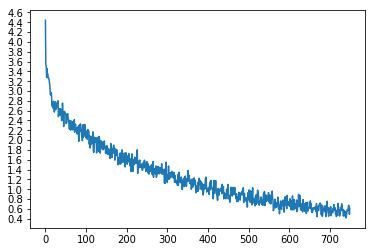

In [26]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [27]:
evaluateRandomly(encoder1, attn_decoder1)

> elle est amicale avec tout le monde .
= she is friendly to everybody .
< she is friendly to everybody . <EOS>

> je suis disponible .
= i m available .
< i m free . <EOS>

> tu as parfaitement raison .
= you re perfectly right .
< you re totally right . <EOS>

> je suis impatient de te voir danser .
= i m looking forward to seeing you dance .
< i m looking forward to seeing you dance . <EOS>

> je suis trop vieux pour aller en allemagne .
= i m too old to go to germany .
< i m too old to go to drink . <EOS>

> elle n a pas le moral aujourd hui .
= she is in low spirits today .
< she is not in today today . <EOS>

> je suis desole a propos de cette nuit .
= i m sorry about last night .
< i am sorry about last night . <EOS>

> tu compares des choux et des carottes !
= you re comparing apples and oranges !
< you re comparing apples and oranges ! ! <EOS>

> je suis diabetique .
= i m a diabetic .
< i am a . <EOS>

> j insiste que vous devez partir .
= i m adamant that you should go .
< i

### Attention可视化

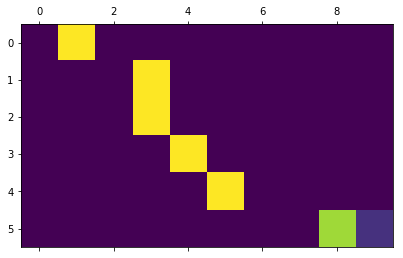

In [28]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me am . <EOS>


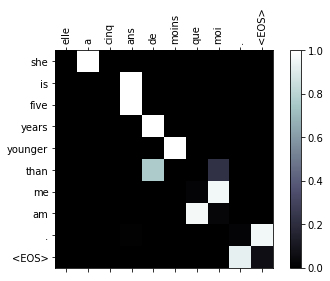

input = elle est trop petit .
output = she is too short . <EOS>


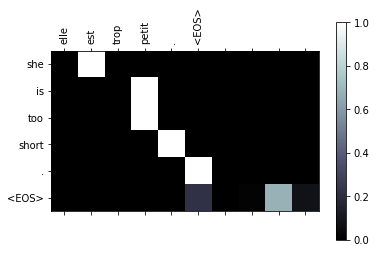

input = je ne crains pas de mourir .
output = i m not to to die . <EOS>


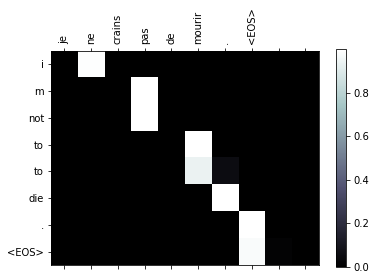

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


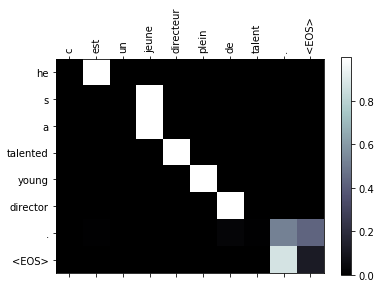

In [29]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")